In [ ]:
!pip install numpyro
!pip install arviz

In [ ]:
import os
import pickle
import numpy as np
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.distributions import LogNormal, Normal, Uniform
from numpyro.infer import MCMC, NUTS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)
numpyro.set_host_device_count(4)

In [ ]:
%cd '/content/drive/My Drive/Bayesian_Binding/bitc_pymc3'
!ls

In [ ]:
numpyro.__version__

'0.10.0'

In [ ]:
KB = 0.0019872041        # in kcal/mol/K
INJ_VOL = 1.2e-5         # in liter
CELL_CONCENTR = 0.1      # milli molar
SYRINGE_CONCENTR = 1.0  # milli molar

HEAT_FILE = "inputs/Mg1EDTAp1a.DAT"
OUT_DIR = "outputs"

In [ ]:
def load_heat_micro_cal(origin_heat_file):
    """
    :param origin_heat_file: str, name of heat file
    :return: DeviceArray, heats in micro calorie
    """

    heats = []
    with open(origin_heat_file) as handle:
        handle.readline()
        for line in handle:
            if len(line.split()) == 6:
                heats.append(np.float(line.split()[0]))

    return jnp.array(heats)

In [ ]:
q_actual_micro_cal = load_heat_micro_cal(HEAT_FILE)
q_actual_cal = q_actual_micro_cal * 1e-6
q_actual_cal

DeviceArray([-2.772430e-05, -2.899697e-05, -2.892312e-05, -2.884158e-05,
             -2.882591e-05, -2.888749e-05, -2.800774e-05, -2.733818e-05,
             -2.065130e-05, -9.139800e-06, -3.761440e-06, -1.943890e-06,
             -1.627770e-06, -1.045790e-06, -1.054640e-06, -1.034880e-06,
             -1.130120e-06, -1.036560e-06, -7.545200e-07, -9.018900e-07,
             -9.904100e-07, -8.517100e-07, -9.327900e-07], dtype=float64)

In [ ]:
n_injections = len(q_actual_cal)
print("# injections:", n_injections)
injection_volumes = [INJ_VOL for _ in range(n_injections)]

# injections: 23


In [ ]:
def heats_TwoComponentBindingModel(V0, DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0, beta, N):
    """
    Expected heats of injection for two-component binding model.

    ARGUMENTS
    V0 - cell volume (liter)
    DeltaVn - injection volumes (liter)
    P0 - Cell concentration (millimolar)
    Ls - Syringe concentration (millimolar)
    DeltaG - free energy of binding (kcal/mol)
    DeltaH - enthalpy of binding (kcal/mol)
    DeltaH_0 - heat of injection (cal)
    beta - inverse temperature * gas constant (mole / kcal)
    N - number of injections

    Returns
    -------
    expected injection heats (calorie)

    """
    Kd = jnp.exp(beta * DeltaG)   # dissociation constant (M)

    # Compute complex concentrations.
    # Pn[n] is the protein concentration in sample cell after n injections
    # (M)
    Pn = jnp.zeros([N], dtype=jnp.float64)
    # Ln[n] is the ligand concentration in sample cell after n injections
    # (M)
    Ln = jnp.zeros([N], dtype=jnp.float64)
    # PLn[n] is the complex concentration in sample cell after n injections
    # (M)
    PLn = jnp.zeros([N], dtype=jnp.float64)

    dcum = 1.0  # cumulative dilution factor (dimensionless)
    for n in range(N):
        # Instantaneous injection model (perfusion)
        # dilution factor for this injection (dimensionless)
        d = 1.0 - (DeltaVn[n] / V0)
        dcum *= d  # cumulative dilution factor
        # total quantity of protein in sample cell after n injections (mol)
        P = V0 * P0 * 1.e-3 * dcum
        # total quantity of ligand in sample cell after n injections (mol)
        L = V0 * Ls * 1.e-3 * (1. - dcum)
        # complex concentration (M)
        PLn = jax.ops.index_add(PLn, jax.ops.index[n], 
                                0.5 / V0 * ((P + L + Kd * V0) - jnp.sqrt( (P + L + Kd * V0) ** 2 - 4 * P * L) ))
        # free protein concentration in sample cell after n injections (M)
        Pn = jax.ops.index_add(Pn, jax.ops.index[n], P / V0 - PLn[n])
        # free ligand concentration in sample cell after n injections (M)
        Ln = jax.ops.index_add(Ln, jax.ops.index[n], L / V0 - PLn[n])

    # Compute expected injection heats.
    # q_n_model[n] is the expected heat from injection n
    q_n = jnp.zeros([N], dtype=jnp.float64)
    # Instantaneous injection model (perfusion)
    # first injection
    q_n = jax.ops.index_add(q_n, jax.ops.index[0], (DeltaH * V0 * PLn[0])*1000. + DeltaH_0)

    for n in range(1, N):
        d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
        # subsequent injections
        q_n = jax.ops.index_add(q_n, jax.ops.index[n], (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0)

    return q_n

def logsigma_guesses(q_n_cal):
    log_sigma_guess = jnp.log(q_n_cal[-4:].std())
    log_sigma_min = log_sigma_guess - 10
    log_sigma_max = log_sigma_guess + 5
    return log_sigma_min, log_sigma_max

def deltaH0_guesses(q_n_cal):
    heat_interval = (q_n_cal.max() - q_n_cal.min())
    DeltaH_0_min = q_n_cal.min() - heat_interval
    DeltaH_0_max = q_n_cal.max() + heat_interval
    return DeltaH_0_min, DeltaH_0_max

def lognormal_prior(name, stated_value, uncertainty):
    """
    :param name: str
    :param stated_value: float
    :uncertainty: float
    :rerurn: numpyro.Lognormal
    """
    m = stated_value
    v = uncertainty ** 2
    name = numpyro.sample(name, dist.LogNormal(loc=jnp.log(m / jnp.sqrt(1 + (v / (m ** 2)))), 
                                               scale=jnp.sqrt(jnp.log(1 + v / (m**2) )) ))

    return name

def uniform_prior(name, lower, upper):
    """
    :param name: str
    :param lower: float
    :param upper: float
    :return: numpyro.Uniform
    """
    name = numpyro.sample(name, dist.Uniform(low=lower, high=upper))
    return name

def param(q_actual_cal, injection_volumes, cell_concentration, syringe_concentration,
          cell_volume, temperature, dcell, dsyringe,
          uniform_P0=False, P0_min=None, P0_max=None, 
          uniform_Ls=False, Ls_min=None, Ls_max=None):
    """
    :param q_actual_cal: observed heats in calorie, array-like
    :param injection_volumes: injection volumes in liter, array-like
    :param cell_concentration: concentration of the sample cell in milli molar, float
    :param syringe_concentration: concentration of the syringe in milli molar, float
    :param cell_volume: volume of sample cell in liter, float #check the instrutment 
    :param temperature: temprature in kelvin, float
    :param dcell: relative uncertainty in cell concentration, float
    :param dsyringe: relative uncertainty in syringe concentration, float
    :param uniform_P0: if True, use uniform prior for cell concentration, bool
    :param P0_min: only use if uniform_P0 is True, float
    :param P0_max: only use if uniform_P0 is True, float
    :param uniform_Ls: if True, use uniform prior for syringe concentration, bool
    :param Ls_min: only use if uniform_Ls is True, float
    :param Ls_max: only use if uniform_Ls is True, float

    :return: priors for P0, Ls, DeltaG, DeltaH, DeltaH_0, log_sigma
    """
    if uniform_P0 and (P0_min is None or P0_max is None):
        raise ValueError("If uniform_P0 is True, both P0_min and P0_max must be provided")
    
    if uniform_Ls and (Ls_min is None or Ls_max is None):
        raise ValueError("If uniform_Ls is True, both Ls_min and Ls_max must be provided")
    
    DeltaH_0_min, DeltaH_0_max = deltaH0_guesses(q_actual_cal)
    log_sigma_min, log_sigma_max = logsigma_guesses(q_actual_cal)

    stated_P0 = cell_concentration
    uncertainty_P0 = dcell * stated_P0

    stated_Ls = syringe_concentration
    uncertainty_Ls = dsyringe * stated_Ls

    # prior for receptor concentration
    if uniform_P0:
        print("Uniform prior for P0")
        P0 = uniform_prior("P0", lower=P0_min, upper=P0_max)
    else:
        P0 = lognormal_prior("P0", stated_value=stated_P0, uncertainty=uncertainty_P0)

    # prior for ligand concentration
    if uniform_Ls:
        print("Uniform prior for Ls")
        Ls = uniform_prior("Ls", lower=Ls_min, upper=Ls_max)
    else:
        Ls = lognormal_prior("Ls", stated_value=stated_Ls, uncertainty=uncertainty_Ls)
  
    # prior for DeltaG, DeltaH, DeltaH_0 and log_sigma
    DeltaG = uniform_prior("DeltaG", lower=-40., upper=4.)
    DeltaH = uniform_prior("DeltaH", lower=-100., upper=100.)
    DeltaH_0 = uniform_prior("DeltaH_0", lower=DeltaH_0_min, upper=DeltaH_0_max)
    log_sigma = uniform_prior("log_sigma", lower=log_sigma_min, upper=log_sigma_max)

    return P0, Ls, DeltaG, DeltaH, DeltaH_0, log_sigma

def make_TwoComponentBindingModel(q_actual_cal, injection_volumes, 
                                  cell_concentration, syringe_concentration,
                                  cell_volume=0.001434,
                                  temperature=298.15,
                                  dcell=0.1, dsyringe=0.1,
                                  uniform_P0=False, P0_min=None, P0_max=None, 
                                  uniform_Ls=False, Ls_min=None, Ls_max=None):
    """
    to create a model
    :param q_actual_cal: observed heats in calorie, array-like
    :param injection_volumes: injection volumes in liter, array-like
    :param cell_concentration: concentration of the sample cell in milli molar, float
    :param syringe_concentration: concentration of the syringe in milli molar, float
    :param cell_volume: volume of sample cell in liter, float #check the instrutment 
    :param temperature: temprature in kelvin, float
    :param dcell: relative uncertainty in cell concentration, float
    :param dsyringe: relative uncertainty in syringe concentration, float
    :param uniform_P0: if True, use uniform prior for cell concentration, bool
    :param P0_min: only use if uniform_P0 is True, float
    :param P0_max: only use if uniform_P0 is True, float
    :param uniform_Ls: if True, use uniform prior for syringe concentration, bool
    :param Ls_min: only use if uniform_Ls is True, float
    :param Ls_max: only use if uniform_Ls is True, float
    
    :return: an instance of numpyro.model
    """
    assert len(q_actual_cal) == len(injection_volumes), "q_actual_cal and injection_volumes must have the same len."
    
    V0 = cell_volume
    DeltaVn = injection_volumes
    beta = 1 / KB / temperature
    n_injections = len(q_actual_cal)
    
    P0, Ls, DeltaG, DeltaH, DeltaH_0, log_sigma = param(q_actual_cal, injection_volumes, 
                                                        cell_concentration, syringe_concentration, 
                                                        cell_volume, temperature, dcell, dsyringe,
                                                        uniform_P0, P0_min, P0_max,
                                                        uniform_Ls, Ls_min, Ls_max)

    sigma_cal = jnp.exp(log_sigma)
    q_model_cal = heats_TwoComponentBindingModel(cell_volume, DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0, beta, n_injections)

    numpyro.sample('q_obs', dist.Normal(loc=q_model_cal, scale=sigma_cal), obs=q_actual_cal)

In [ ]:
rng_key = random.split(random.PRNGKey(0))

In [ ]:
kernel = NUTS(make_TwoComponentBindingModel)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=10000, num_chains=4, progress_bar=False)
mcmc.run(rng_key, q_actual_cal, injection_volumes, CELL_CONCENTR, SYRINGE_CONCENTR)
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     DeltaG     -8.99      0.08     -8.99     -9.12     -8.87   7859.73      1.00
     DeltaH     -2.10      0.15     -2.10     -2.34     -1.86   5488.17      1.00
   DeltaH_0     -0.00      0.00     -0.00     -0.00     -0.00  11006.09      1.00
         Ls      1.12      0.08      1.12      0.98      1.24   5377.76      1.00
         P0      0.09      0.01      0.09      0.08      0.10   5376.25      1.00
  log_sigma    -14.78      0.16    -14.79    -15.05    -14.52   8316.83      1.00

Number of divergences: 0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22829c6940>,
      dtype=object)

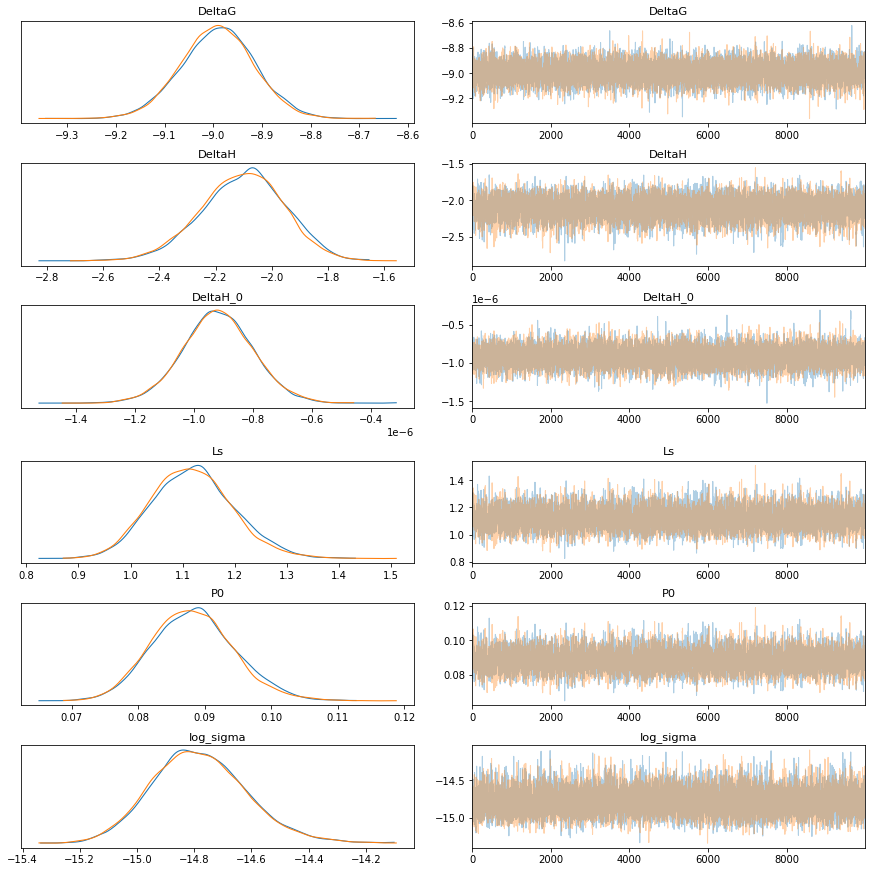

In [ ]:
trace = mcmc.get_samples(group_by_chain=True)
data = az.convert_to_inference_data(trace)
az.plot_trace(data)
plt.savefig(os.path.join(OUT_DIR, "numpyro_trace.pdf"))

In [ ]:
pickle.dump(make_TwoComponentBindingModel, open(os.path.join(OUT_DIR, "numpyro.pickle"), "wb"))
pickle.dump(trace, open(os.path.join(OUT_DIR, "numpyro_trace.pickle"), "wb"))